In [1]:
# interactive, parametric exploration of simulation and predictive model in tandem
#
# Author: Alex Braafladt
#
# Version: v1 Initial creation 5/17/2022
#
# References:
#   -

## Interactive, Parametric Exploration

This notebook showcases a simple interactive app for qualitatively exploring the predictive accuracy across the input ranges considered.

In [2]:
# imports
# probabilistic and statistical modeling
import openturns as ot
import openturns.viewer as viewer
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as st
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

# data and numerical functions
import numpy as np
import pandas as pd

# graphing and visualization functions
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

# order reduction and data conditioners
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

# design of experiments
from doepy import build

# os operations
import os as os
import sys
import datetime as dt
import pickle
from joblib import dump, load
import time

# app plotting
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output, State
from jupyter_dash import JupyterDash

# modeling code
from fit_pca import *
from sklearn.metrics import mean_squared_error, r2_score

# custom functions
import stats_functions as sf
import copula_gen_data as cpgen
from emulator_classes import Simulation, Data, Experiment, Analysis, AsdlModel

In [3]:
# set up file I/O

# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'modelinteract' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\distribution-surrogates
Data save directory: C:\Users\alexb\PycharmProjects\distribution-surrogates\output\\modelinteract20220525165138


#### Load the model trained in the previous notebook

First, we load the trained model.

In [4]:
# import model and simulation objects to work with

# NOTE THIS PATH NEEDS TO BE MANUALLY UPDATED TO POINT TO THE JOBLIB SAVED FILE
model_path = newoutputdir + '/modelbuidling20220517173950/trained_gp_model.joblib'
trained_model = load(model_path)

#### Interactive app

The interactive app is set up through dash, with a function called each time a button is pressed, and inputs read in from slider bars. Run the code below to set up the function and then the app, and then open the link below in a browser to run the app.

In [5]:
# parametric function
def dash_parametric_model(x_input, romModel, scaler, ecdfyin, discrete_flags, custom_bins=None, num_samples=1000, num_dists=30, seed=42):
    """Function to parametrically generate a plot comparing ecdfs from model and actual simulation"""
    # get predicted distribution arrays from model
    x_input_exp = np.array([x_input, x_input])
    y_predict = romModel.predict(x_input_exp)
    # format into 3d array shape (should end up as (2,1000,30) to work correctly with model setup)
    y_predict_formatted = cpgen.pca_destack(y_predict.T, num_samples, num_dists)
    predicted_data = Data(ecdf_vals=(ecdfyin, y_predict_formatted), scaler=scaler, discrete_flags=discrete_flags, custom_bins=custom_bins)
    predicted_data.data_setup_from_ecdfs()
    y_predict_final = predicted_data.scaled_ecdfs[1][0]
    ecdfyin = predicted_data.scaled_ecdfs[0]
    # simulate actual data
    local_sim = Simulation(x_input, corr_rng_seed=seed)
    local_samples = np.array(local_sim.get_joint_distribution_samples(1000))
    local_samples = np.expand_dims(local_samples, axis=0)
    local_data = Data(samples=local_samples, custom_bins=custom_bins, scaler=scaler, discrete_flags=discrete_flags)
    local_data.data_setup_from_samples()
    y_true_final = local_data.scaled_ecdfs[1][0]
    # plot comparison
    fig = make_subplots(rows=10, cols=3, shared_yaxes=False)
    for i in range(10):
        for j in range(3):
            # df for plotting
            if i == 0 and j == 0:
                fig.add_trace(go.Scatter(x=y_true_final[:,3*i+j], y=ecdfyin, mode='lines', name='true',
                                         line=dict(color='#1f77b4', width=1),
                                         marker=dict(color=[0, 1], coloraxis="coloraxis")), row=i+1, col=j+1)
                fig.add_trace(go.Scatter(x=y_predict_final[:,3*i+j], y=ecdfyin, mode='lines', name='model',
                                         line=dict(color='#ff7f0e', width=1),
                                         marker=dict(color=[0, 1], coloraxis="coloraxis")), row=i+1, col=j+1)
            else:
                fig.add_trace(go.Scatter(x=y_true_final[:,3*i+j], y=ecdfyin, mode='lines', name='true',
                                         line=dict(color='#1f77b4', width=1), showlegend=False,
                                         marker=dict(color=[0, 1], coloraxis="coloraxis")), row=i+1, col=j+1)
                fig.add_trace(go.Scatter(x=y_predict_final[:,3*i+j], y=ecdfyin, mode='lines', name='model',
                                         line=dict(color='#ff7f0e', width=1), showlegend=False,
                                         marker=dict(color=[0, 1], coloraxis="coloraxis")), row=i+1, col=j+1)
    fig.update_layout(height=1000, width=1400, title_text='ECDF comparison', coloraxis=dict(colorscale='algae'))
    fig.update_yaxes(showgrid=False, showticklabels=False)
    # hardcoded save file - update later to take in argument data save directory
    np.save(datasavedir+'/current_model_data.npy', y_predict_final)
    np.save(datasavedir+'/current_true_data.npy', y_true_final)
    np.save(datasavedir+'/current_ecdfy_data.npy', ecdfyin)
    return fig
# test_x = np.array([1000., 250., 0., 0.5, 0.2, 45., 1., 3., 1., 2.2, 0.3, 0.6, 3., 8., 2.])
# test_fig = dash_parametric_model(x_input=test_x, romModel=gpROM, scaler=data_train.scaler,
#                                  discrete_flags=discrete_flags, ecdfyin=data_train.scaled_ecdfs[0])

In [6]:
# dash setup for selecting inputs and comparing simulation and model

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id='graph-of-distributions'),
    html.Button(id='submit-button-state', n_clicks=0, children='Submit'),
    html.Div(id='output-state'),
    dcc.Slider(trained_model.input_ranges[0][0], trained_model.input_ranges[0][1], id='input-1-slider-state', value=1000.),
    dcc.Slider(trained_model.input_ranges[1][0], trained_model.input_ranges[1][1], id='input-2-slider-state', value=6500.),
    dcc.Slider(trained_model.input_ranges[2][0], trained_model.input_ranges[2][1], id='input-3-slider-state', value=-1.),
    dcc.Slider(trained_model.input_ranges[3][0], trained_model.input_ranges[3][1], id='input-4-slider-state', value=0.2),
    dcc.Slider(trained_model.input_ranges[4][0], trained_model.input_ranges[4][1], id='input-5-slider-state', value=0.2),
    dcc.Slider(trained_model.input_ranges[5][0], trained_model.input_ranges[5][1], id='input-6-slider-state', value=45.),
    dcc.Slider(trained_model.input_ranges[6][0], trained_model.input_ranges[6][1], id='input-7-slider-state', value=1.2),
    dcc.Slider(trained_model.input_ranges[7][0], trained_model.input_ranges[7][1], id='input-8-slider-state', value=3.0),
    dcc.Slider(trained_model.input_ranges[8][0], trained_model.input_ranges[8][1], id='input-9-slider-state', value=0.6),
    dcc.Slider(trained_model.input_ranges[9][0], trained_model.input_ranges[9][1], id='input-10-slider-state', value=2.2),
    dcc.Slider(trained_model.input_ranges[10][0], trained_model.input_ranges[10][1], id='input-11-slider-state', value=0.7),
    dcc.Slider(trained_model.input_ranges[11][0], trained_model.input_ranges[11][1], id='input-12-slider-state', value=0.6),
    dcc.Slider(trained_model.input_ranges[12][0], trained_model.input_ranges[12][1], id='input-13-slider-state', value=12.),
    dcc.Slider(trained_model.input_ranges[13][0], trained_model.input_ranges[13][1], id='input-14-slider-state', value=8.),
    dcc.Slider(trained_model.input_ranges[14][0], trained_model.input_ranges[14][1], id='input-15-slider-state', value=2.)
])


@app.callback(Output('output-state', 'children'),
              Input('submit-button-state', 'n_clicks'),
              State('input-1-slider-state', 'value'),
              State('input-2-slider-state', 'value'),
              State('input-3-slider-state', 'value'),
              State('input-4-slider-state', 'value'),
              State('input-5-slider-state', 'value'),
              State('input-6-slider-state', 'value'),
              State('input-7-slider-state', 'value'),
              State('input-8-slider-state', 'value'),
              State('input-9-slider-state', 'value'),
              State('input-10-slider-state', 'value'),
              State('input-11-slider-state', 'value'),
              State('input-12-slider-state', 'value'),
              State('input-13-slider-state', 'value'),
              State('input-14-slider-state', 'value'),
              State('input-15-slider-state', 'value'))
def update_output(n_clicks, input1, input2, input3, input4, input5, input6, input7, input8, input9,
                  input10, input11, input12, input13, input14, input15):
    return u'''
        The Button has been pressed {} times,
        Inputs: "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}",
    '''.format(n_clicks, str(input1), str(input2), str(input3), str(input4), str(input5), str(input6),
               str(input7), str(input8), str(input9), str(input10), str(input11), str(input12),
               str(input13), str(input14), str(input15))


@app.callback(Output('graph-of-distributions', 'figure'),
              Input('submit-button-state', 'n_clicks'),
              State('input-1-slider-state', 'value'),
              State('input-2-slider-state', 'value'),
              State('input-3-slider-state', 'value'),
              State('input-4-slider-state', 'value'),
              State('input-5-slider-state', 'value'),
              State('input-6-slider-state', 'value'),
              State('input-7-slider-state', 'value'),
              State('input-8-slider-state', 'value'),
              State('input-9-slider-state', 'value'),
              State('input-10-slider-state', 'value'),
              State('input-11-slider-state', 'value'),
              State('input-12-slider-state', 'value'),
              State('input-13-slider-state', 'value'),
              State('input-14-slider-state', 'value'),
              State('input-15-slider-state', 'value'))
def update_figure(n_clicks, input1, input2, input3, input4, input5, input6, input7, input8, input9,
                  input10, input11, input12, input13, input14, input15):
    input_array = np.array([float(input1), float(input2), float(input3), float(input4), float(input5),
                            float(input6), float(input7), float(input8), float(input9), float(input10),
                            float(input11), float(input12), float(input13), float(input14), float(input15)])
    return dash_parametric_model(x_input=input_array, romModel=trained_model.model, scaler=trained_model.true_data_train.scaler,
                                 ecdfyin=trained_model.true_data_train.scaled_ecdfs[0],
                                 discrete_flags=trained_model.true_data_train.discrete_flags)

In [7]:
app.run_server(port=8000)

Dash app running on http://127.0.0.1:8000/


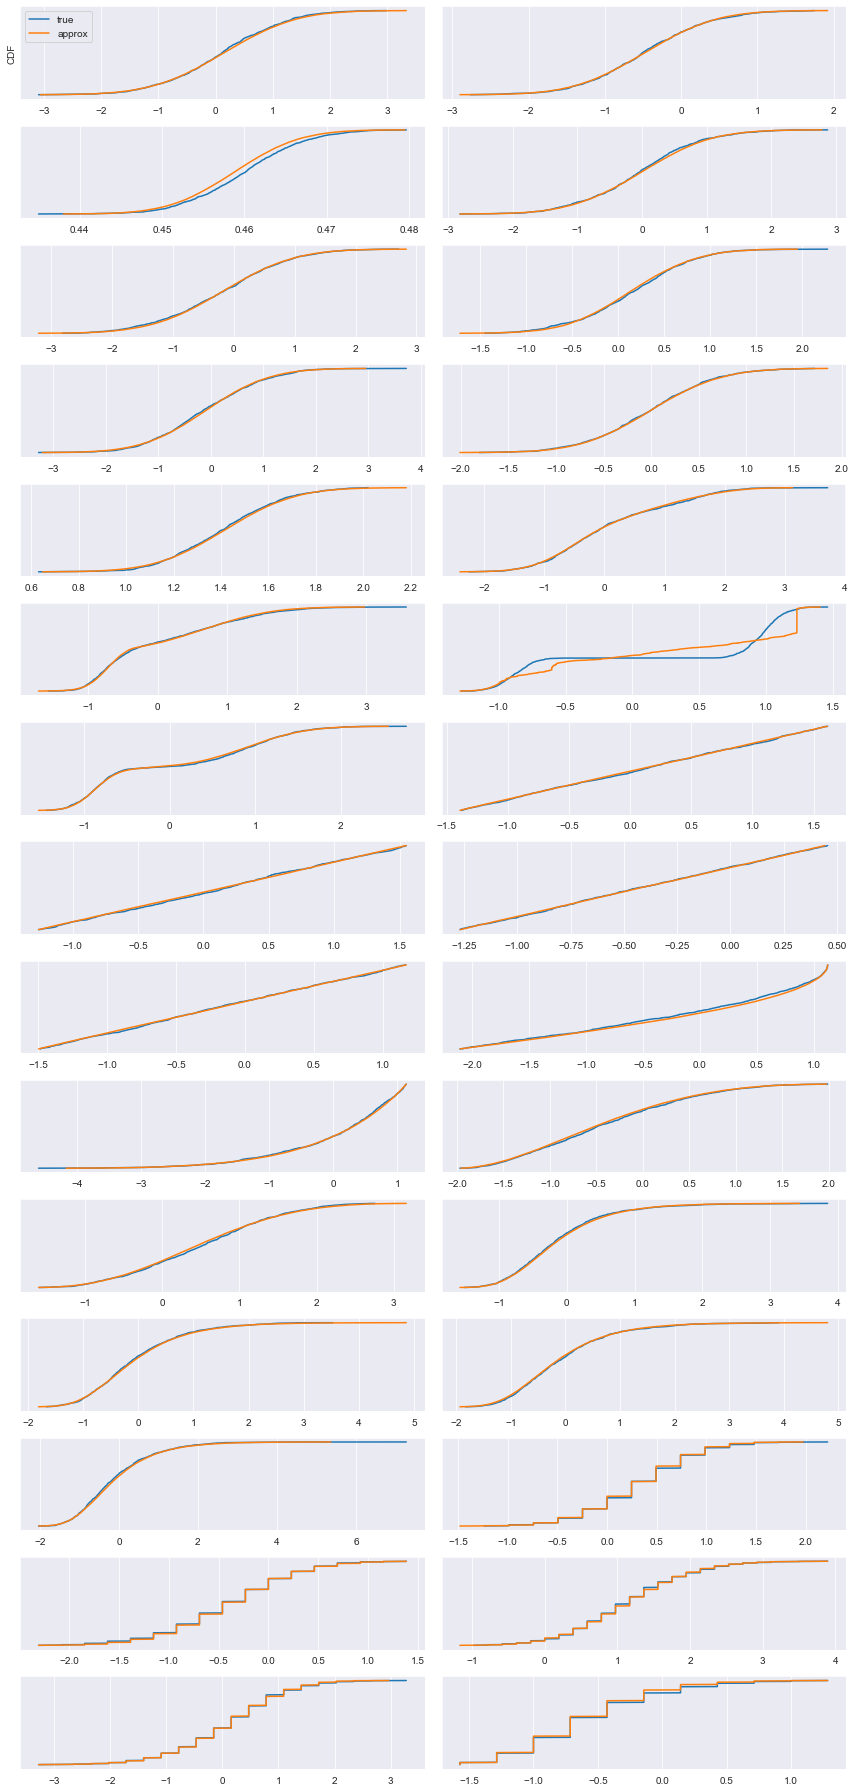

In [11]:
# save a matplotlib figure - currently using hardcoded data access
# get data
true_data = np.load(datasavedir+'/current_true_data.npy')
model_data = np.load(datasavedir+'/current_model_data.npy')
ecdfy_data = np.load(datasavedir+'/current_ecdfy_data.npy')
# plot data
fig, ax = plt.subplots(15, 2, figsize=(12,25))
ax = ax.ravel()
for i in range(30):
    ax[i].plot(true_data[:,i], ecdfy_data)
    ax[i].plot(model_data[:,i], ecdfy_data)
    ax[i].set_yticks(())
ax[0].set_ylabel("CDF")
ax[0].legend(['true', 'approx'], loc='best')
fig.tight_layout()
plot_title = 'Comparison of modeled and true data at selected input point'
fig.savefig(datasavedir + '/' + plot_title + '.png')